## Validate the AB pair PPDF calculation

### Imports

In [1]:
import sys
sys.path.insert(0, '..')
import pymatcal
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

### Read in the configuration. 
The configuration read-in routine should already been tested by `get_config.ipynb`

In [2]:
config = pymatcal.get_config('config-pair-ppdf.yml')

### Formula
$$a_{ij}= \frac{1}{N_j}\sum_{i' \in i}\sum_{j' \in j}\frac{\Omega_{i'j'}}{4\pi} \cdot e^{-\int_{L_s}^{L_p} \mu(l)dl}\left(1-e^{-\int_{L_p}^{L_q} \mu(l)dl}\right)$$

+ $N_j$ is the number of sub-elements in $j_{\textit{th}}$ source voxel.
+ $\Omega_{i'j'}$ s the solid angle of $i_{\textit{th}}'$ sub-element in the detector to $j_{\textit{th}}'$ sub-element in the image volumn(or FOV).
+ $L_s$ is the position of source $j'_{\textit{th}}$ sub-voxel on line L.
+ $L_p$ is the position of the photon incident on the $i'_{\textit{th}}$ sub-element in the detector.
+ $L_q$ is the position of the photon exit from $i'_{\textit{th}}$ sub-element in the detector.
+ $\mu(l)$ is the linear attenuation coefficient.

### Get point A
A index is 85

In [3]:
pointA=pymatcal.get_img_voxel_center(85, config['img nvx'], config['mmpvx'])
print('point A:',pointA)

point A: [ 0. 30.  0.]


### Show active detectors

In [4]:
print("Number of active detector units:",config['active det'].shape[0])
print(config['active det'])

Number of active detector units: 2
[[11.   21.   21.   27.   -0.5   0.5   5.    0.48]
 [ 0.   10.    9.   15.   -0.5   0.5   2.    0.48]]


### Setup subdivisions pairs
We pick the first active detector in the test

In [5]:
det_subdivs = pymatcal.get_det_subdivs(
    config['active det'][0], config['det nsub'])
img_subdivs = pymatcal.get_img_subdivs(config['mmpvx'], config['img nsub'])
pAs = img_subdivs['coords']+pointA
pBs = det_subdivs['coords']
pAs = pymatcal.coord_transform(
    pymatcal.get_mtransform(config['angle'], -config['dist'], 5), pAs)
abpairs = pymatcal.get_AB_pairs(pAs, pBs)

### Set blocking detector units array and the focused detector unit

In [6]:
blocks = config["det geoms"][config["det geoms"][:,6] != config["active det"][0][6]]
focus_det = np.array([config["active det"][0]])

### Get intersections

In [7]:
intersections_blk = pymatcal.get_intersections_2d(blocks,abpairs)
intersections_det = pymatcal.get_intersections_2d(focus_det,abpairs)

### Plot

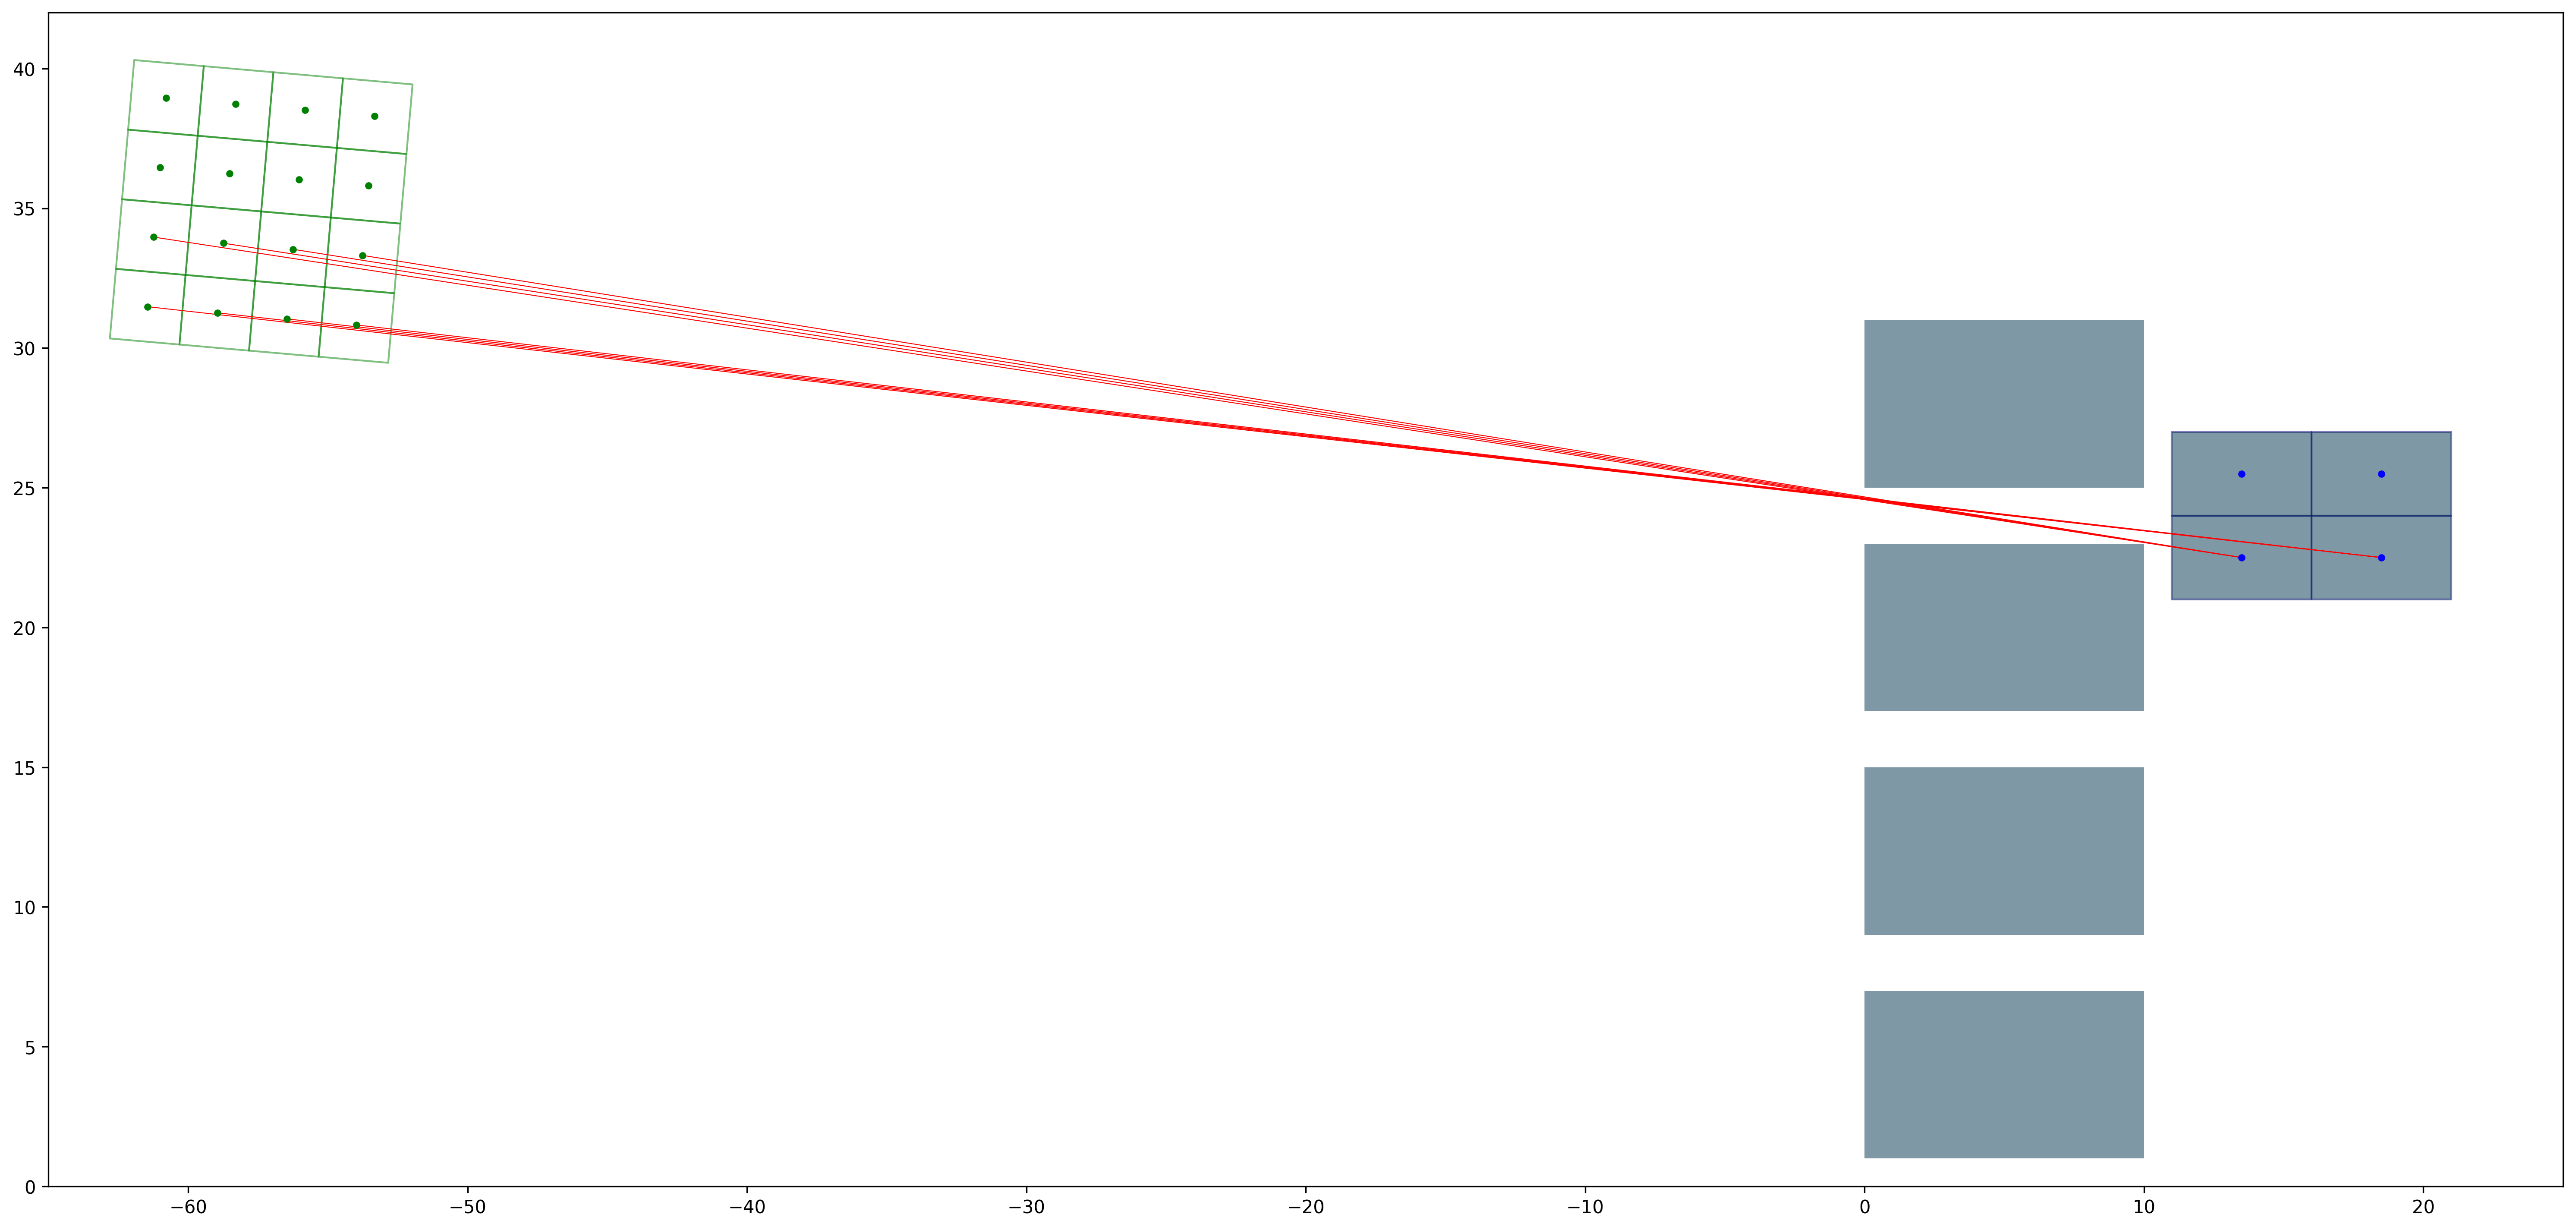

In [8]:
det_subdiv_list = [
    mpl.patches.Rectangle(
        xy[:2] - det_subdivs["incs"][:2] * 0.5,
        det_subdivs["incs"][0],
        det_subdivs["incs"][1],
    )
    for xy in pBs
]
subdiv_inc = np.array(
    [
        config["mmpvx"][0] / config["img nsub"][0],
        config["mmpvx"][1] / config["img nsub"][1],
    ]
)
img_subdiv_list = [
    mpl.patches.Rectangle(
        xy - subdiv_inc * 0.5,
        subdiv_inc[0],
        subdiv_inc[1],
        angle=-config['angle'],
        rotation_point=(xy[0], xy[1]),
    )
    for xy in pAs[:, :2]
]

fig, ax = plt.subplots(figsize=(20, 10), dpi=300)
pc = mpl.collections.PatchCollection(
    img_subdiv_list, ec=(0, 0.5, 0, 0.5), fc="none")
pc1 = mpl.collections.PatchCollection(
    det_subdiv_list, ec=(0, 0, 0.5, 0.5), fc="none")

passIndx = np.all(intersections_blk == 0, axis=0)
idx = 0
for pair in abpairs[passIndx]:
# for pair in abpairs:
    ax.plot(pair[0::3], pair[1::3], "-", c="r", ms=10, lw=0.5, zorder=12)
    idx += 1

block_list = [
    mpl.patches.Rectangle((geom[0], geom[2]),
                          geom[1] - geom[0], geom[3] - geom[2])
    for geom in config["det geoms"]
]
pc2 = mpl.collections.PatchCollection(
    block_list, fc=(0, 0.2, 0.3, 0.5), ec="none", zorder=10
)
ax.add_collection(pc2)
ax.plot(pAs[:, 0], pAs[:, 1], ".", color=(0, 0.5, 0, 1), ms=6, zorder=15)
ax.plot(pBs[:, 0], pBs[:, 1], ".", color=(0, 0, 1, 1), ms=6, zorder=15)
pAs_mins = np.min(pAs, axis=0)
pAs_maxs = np.max(pAs, axis=0)
det_mins = np.min(config["det geoms"], axis=0)
det_maxs = np.max(config["det geoms"], axis=0)
ax.set_xlim(-65, 25)
ax.set_ylim(0, 42)

ax.add_collection(pc)
ax.add_collection(pc1)
ax.set_aspect("equal")
fig.tight_layout()